#### Exercise 1 - Clustering

##### Bisecting K-Means

This first cell provides all the neccessary functions for completing
the divisive K-means algorithm. 

In [5]:
import numpy as np
from sklearn import preprocessing as pp, datasets
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

def bkmeans(X, k_clusters, iter):
    clusters = []
    clusters = findClusters(X, k_clusters, iter, clusters)
    merged = mergeClusters(clusters)
    sorted = sorter(X, merged)
    return sorted[:, 2]


def sorter(A, B):
    """
    Function by Rafael Martins

    Uses three sorts. Two to align A and B. And one sort to fit B back into the order of A.

    """
    index = np.arange(A.shape[0])[A[:, 0].argsort()].argsort()
    return B[B[:, 0].argsort()][index]


def mergeClusters(clusters):
    # Pop first cluster the initial group
    merged = np.array(clusters.pop(0)[0])
    merged = np.c_[merged, np.zeros(merged.shape[0])]

    # Merge the rest
    for idx, cluster in enumerate(clusters):
        cluster = np.c_[cluster[0], np.zeros(cluster[0].shape[0])]
        cluster[:, 2] = idx + 1  # set index of cluster
        merged = np.append(merged, cluster, axis=0)
    return merged


def nextSplit(saved_clusters):
    largest_sse = 0

    for idx, cluster in enumerate(saved_clusters):
        # X values of indexes,

        sse = sum(sum((cluster[0] - cluster[1]) ** 2))
        if sse > largest_sse:
            largest_sse = sse
            splitIdx = idx

    return saved_clusters.pop(splitIdx)[0]


def findClusters(X, k_clusters, iter, saved_clusters):
    if len(X) / 2 < 2:
        raise Exception("Cannot split. Reduce nr of clusters for data set.")

    # Split into two clusters
    clf = KMeans(n_clusters=2, n_init=iter)

    # Predictions
    pred = clf.fit_predict(X)

    # Add clusters to list
    saved_clusters.append((X[pred == 0], clf.cluster_centers_[0]))
    saved_clusters.append((X[pred == 1], clf.cluster_centers_[1]))

    # Exit condition
    if len(saved_clusters) == k_clusters:
        return saved_clusters

    next = nextSplit(saved_clusters)

    return findClusters(next, k_clusters, iter, saved_clusters)

##### Exercise 2. Sammon Mapping

The implementation of sammons mapping works by minimizing
the stress function known as Sammons Stress using a
gradient descent approach with partial derivatives.

I have noticed that the implementation is quite sensitive for large values
of alpha (learning rate), so the best approach is to use many iterations with low alpha which takes quite a while
since the function is very slow unfortunately.

<strong>Edit:</strong> I managed to vectorize the previously approved solution to speed up the process. 
The vectorized version of sammons mapping is magnitudes faster than the iterative approach, however the current
implementation will most likely run into memory issues if tested on huge sets because 
huge matrix multiplications aren't buffered.

(the previously approved solution is found under iterative_sammon.py)

In [6]:
from scipy.spatial.distance import pdist, squareform

def sammon(X, iter, threshold, alpha):
    np.random.seed(10)
    y = np.random.rand(X.shape[0], 2)

    # X pairwise distances
    dist_x = squareform(pdist(X))
    dist_x_sum = np.sum(dist_x)
    c = np.divide(-2, dist_x_sum)

    for it in range(0, iter):
        # Y pairwise distances
        dist_y = squareform(pdist(y))

        # Stress
        E = ((np.divide(1, dist_x, where=dist_x != 0)) * np.power(np.subtract(dist_x, dist_y), 2)).sum()

        #print(f"E({it}): {E}")

        if E < threshold:
            print("Threshold exceeded! Stopping.")
            return y

        #################
        # First partial
        #################

        # For all i (compared to one entire iteration of i), pairwise difference with y[j] ex shape: 600,600,2
        diff_ij = (y[:, None] - y)
        xx, yy = diff_ij[0].shape

        # Filter out all zeroes from all pairwise differences from all y[i]-y[j]
        diff_ij = diff_ij.reshape(xx, xx, 2)

        # Calc all distances at once
        dist_xy = dist_x - dist_y
        mult_xy = np.multiply(dist_y, dist_x)

        # After calculations, flatten the arrays before the sum
        dist_xy = dist_xy.reshape(xx * xx, 1)
        mult_xy = mult_xy.reshape(xx * xx, 1)

        # No division by zero!
        mult_xy[np.where(mult_xy < 1e-9)] = 1e-9

        # Flatten the diff matrix
        diff_ij = diff_ij.reshape(xx * xx, 2)

        # Sum is now ALL divisions for All i and All j
        summ0 = np.multiply(np.divide(dist_xy, mult_xy, where=mult_xy != 0), diff_ij)

        # Reshape sum again
        summ0 = summ0.reshape(xx, xx, 2)

        # Calculate partial of i
        partial0 = c * np.sum(summ0, axis=0)
        partial0 = -1 * partial0
        #################
        # Second partial
        #################

        # Calc all of part 0
        p0 = np.divide(1, mult_xy, where=mult_xy != 0)

        #  Differences between yi and yj  divided
        dist_y1 = dist_y.reshape(xx * xx, 1)
        p1 = np.divide(diff_ij ** 2, dist_y1, where=dist_y1 != 0)
        p2 = 1 + np.divide(dist_xy, dist_y1, where=dist_y1 != 0)

        calc = (p0 * (dist_xy - p1 * p2))

        summ1 = np.sum(calc.reshape(xx, xx, 2), axis=0)
        partial1 = np.abs(np.divide(np.multiply(-2, summ1), dist_x_sum))
        delta = np.divide(partial0, partial1, where=partial1 != 0)

        y = y - alpha * delta
    return y

##### Exercise 3. Visualization of results

Data sets:

* MNIST - (600, 64). 9 classes: (0.9).

* South African Congenital Heart disease. (472, 9). Classes: positive/negative.

* Wine - (178, 13) 3 classes: (Class_0, class_1, class_2)

##### 3.1.1

Overall I think tSNE performed best on all data, it managed to separate all
data sets quite well compared to PCA and Sammon. 

TSNE seems to have a slight advantage over Sammon on MNIST (row 1) due to the more distinct separation of clusters. For row
two all algorithms struggled to separate the data where PCA and Sammon were pretty much equal and TSNE a bit better.

For the wine set TSNE and Sammon separated the clusters very well while PCA had a few more outliers.
 
##### 3.1.2

The MNIST and Wine classes seem to be well suited for separation while the True/Positive classes of the 
SA Congenital Heart Disease set seems much harder to distinguish between.
For the heart set the difficulty to separate the data might be due to small variances and dissimilarities 
between positive and negative which will affect the outcome of PCA and Sammon negatively.



D:\Projekt\anaconda3\lib\site-packages\ipykernel_launcher.py:71: RuntimeWarning: overflow encountered in multiply
D:\Projekt\anaconda3\lib\site-packages\ipykernel_launcher.py:74: RuntimeWarning: overflow encountered in multiply
D:\Projekt\anaconda3\lib\site-packages\ipykernel_launcher.py:42: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


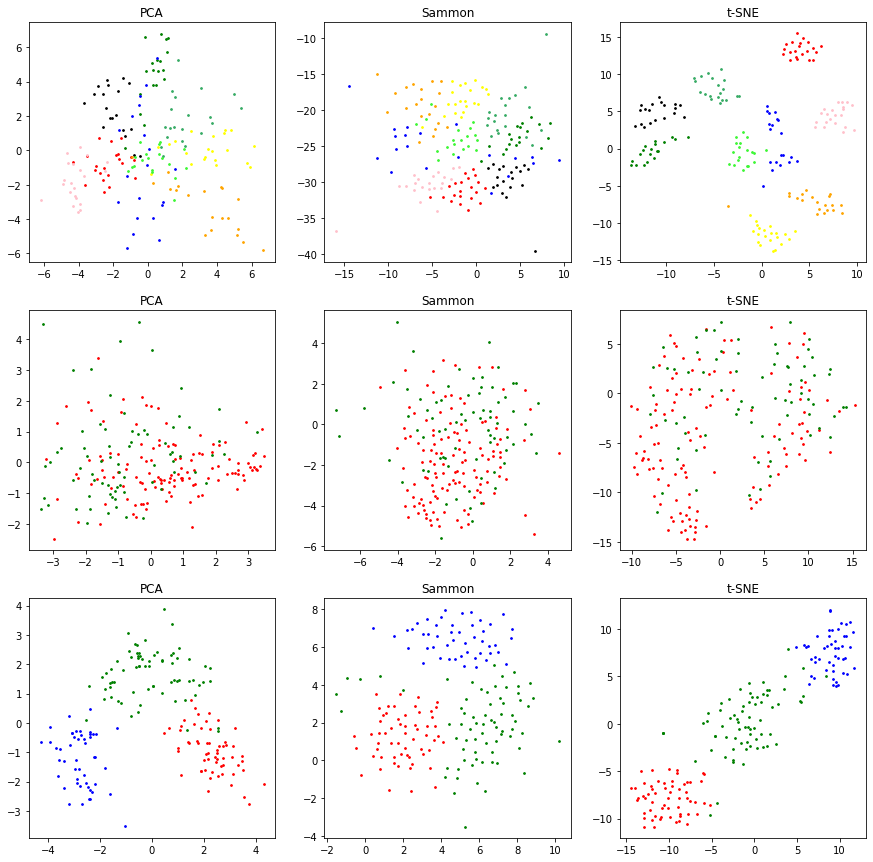

In [7]:
heart = np.genfromtxt('data/sa_heart.csv', delimiter=',', dtype=float, skip_header=True, usecols=(0, 1, 2, 3, 4, 5, 6, 7, 8))
digits = datasets.load_digits()
wine = datasets.load_wine()

X_digits = pp.StandardScaler().fit_transform(digits.data[:200, 1:])
X_heart = pp.StandardScaler().fit_transform(heart[:200, :])
X_wine = pp.StandardScaler().fit_transform(wine.data[:178, :])

y_heart = np.genfromtxt('data/sa_heart.csv', delimiter=',', dtype=float, skip_header=True, usecols=(9))
y_heart = y_heart[:200]
y_heart[y_heart == 1] = 0
y_heart[y_heart == 2] = 1
y_digits = digits.target[:200]
y_wine = wine.target[:200]


pca = PCA(n_components=2)
tsne = TSNE(n_components=2)

# Fit
Xn2 = sammon(X_digits.copy(), 5000, 1e-6, 0.02)
Xn1 = pca.fit_transform(X_digits.copy())
Xn3 = tsne.fit_transform(X_digits.copy())

Xn5 = sammon(X_heart.copy(), 2500, 1e-6, 0.02)
Xn4 = pca.fit_transform(X_heart.copy())
Xn6 = tsne.fit_transform(X_heart.copy())
#
Xn8 = sammon(X_wine.copy(), 3000, 1e-6, 0.02)
Xn7 = pca.fit_transform(X_wine.copy())
Xn9 = tsne.fit_transform(X_wine.copy())


# Plots
color = ['red', 'green', 'blue', 'yellow', 'black', 'orange', 'pink', '#37AB65', '#3DF735',
         '#AD6D70', '#EC2504', '#8C0B90', '#C0E4FF', '#27B502', '#7C60A8', '#CF95D7', '#145JKH']

fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(15,15))

def scatter(X, y,clusters, plotNr, title, legend=None):
    for n in range(0, clusters):
        ax = plt.subplot(3, 3, plotNr)
        filter = X[y == n]
        ax.set_title(title)
        ax.scatter(filter[:, 0], filter[:, 1], color=color[n], marker='o', s=3)

scatter(Xn1, y_digits, 9, 1, "PCA")
scatter(Xn2, y_digits, 9, 2, "Sammon")
scatter(Xn3, y_digits, 9, 3, "t-SNE")

scatter(Xn4, y_heart, 2, 4, "PCA")
scatter(Xn5, y_heart, 2, 5, "Sammon")
scatter(Xn6, y_heart, 2, 6, "t-SNE")
#
scatter(Xn7, y_wine, 3, 7, "PCA")
scatter(Xn8, y_wine, 3, 8, "Sammon")
scatter(Xn9, y_wine, 3, 9, "t-SNE")
plt.show()

#### Exercise 3.2

This exercise will visualize t-SNE together with classical Kmeans, Hierarchical and Bisecting K means and compare results.


In [8]:
from sklearn.cluster import KMeans, AgglomerativeClustering

heart = np.genfromtxt('data/sa_heart.csv', delimiter=',', dtype=float, skip_header=True, usecols=(0,1,2,3,4,5,6,7,8))
digits = datasets.load_digits()
wine = datasets.load_wine()

# Preprocessing
X_digits = pp.StandardScaler().fit_transform(digits.data[:200, 1:])  # 25, 0.02, 9 classes
X_heart = pp.StandardScaler().fit_transform(heart[:200, :])  # 100, 0.002
X_wine = pp.StandardScaler().fit_transform(wine.data[:178, :])  # 100, 0.003 3 classes

tsne = TSNE(n_components=2)

# Cluster original data into labels

# DIGITS
kmeans = KMeans(n_clusters=9).fit(X_digits)
pred1 = kmeans.predict(X_digits)
pred2 = AgglomerativeClustering(n_clusters=9).fit_predict(X_digits)
pred3 = bkmeans(X_digits, 9, 3)

# HEARTS
kmeans = KMeans(n_clusters=2).fit(X_heart)
pred4 = kmeans.predict(X_heart)
pred5 = AgglomerativeClustering(n_clusters=2).fit_predict(X_heart)
pred6 = bkmeans(X_heart, 2, 3)

# WINE
kmeans = KMeans(n_clusters=3).fit(X_wine)
pred7 = kmeans.predict(X_wine)
pred8 = AgglomerativeClustering(n_clusters=3).fit_predict(X_wine)
pred9 = bkmeans(X_wine, 3, 3)

# Apply DR technique
Xn1 = tsne.fit_transform(X_digits)
Xn2 = tsne.fit_transform(X_heart)
Xn3 = tsne.fit_transform(X_wine)


### Visualization of results

Hierarchical and Kmeans performed very similarly on all data sets while Bisecting Kmeans struggled on all sets.

The reason for the differences I believe is the top-down approach. The agglomerative will merge the clusters until it has the amount of clusters specified while the divisive will split until x clusters have been found. When tsne later is applied the initial bad splits get even worse due to separation of the points.


D:\Projekt\anaconda3\lib\site-packages\ipykernel_launcher.py:42: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


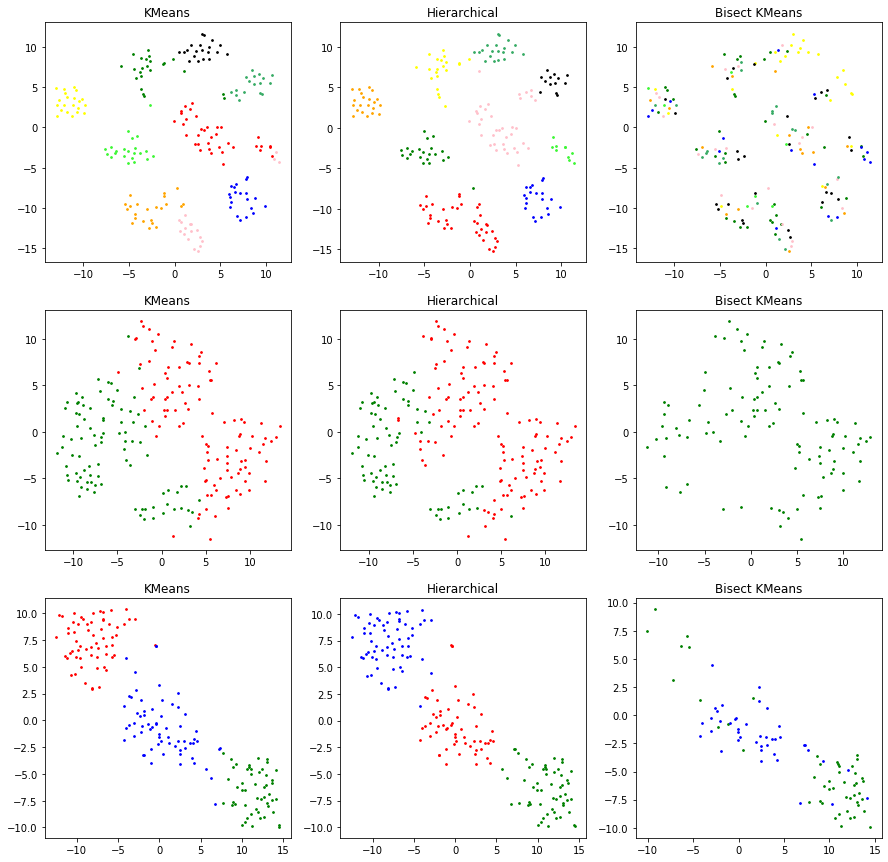

In [9]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(15,15))

# Plot DIGITS
scatter(Xn1, pred1, 9, 1, "KMeans")
scatter(Xn1, pred2, 9, 2, "Hierarchical")
scatter(Xn1, pred3, 9, 3, "Bisect KMeans")

# Plot HEARTS
scatter(Xn2, pred4, 2, 4, "KMeans")
scatter(Xn2, pred5, 2, 5, "Hierarchical")
scatter(Xn2, pred6, 2, 6, "Bisect KMeans")

# Plot WINE
scatter(Xn3, pred7, 3, 7, "KMeans")
scatter(Xn3, pred8, 3, 8, "Hierarchical")
scatter(Xn3, pred9, 3, 9, "Bisect KMeans")

plt.show()
